In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 20

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [1924]:
@everywhere sim_params = @params_mnt begin
    
    # B-field parameters during blue MOT
    B_gradient = 50
    B_offset = (0e-3, 0e-3, 300e-3)
    B_ramp_time = 30e-3
    
    # Laser parameters
    s1 = 2.18
    s2 = 1.82  
    s_ramp_time = 30e-3
    s_ramp_to = 0.7
    pol_imbalance = 0.01
    s_imbalance = (0.0, 0.05, -0.05)
    retro_loss = 0.02
    off_center = (2, -2, -2, 2, 2, 2) .* 1e-3
    pointing_error = (0,0,0,0,0,0)
    pol1_x = [1,0,0]
    pol2_x = [0,0,1]
    voltage = -1.4
    aom_freq = 53.55
    
    # ODT parameters
    # ODT_intensity = 0*1e3/(50e-4)^2
    # ODT_intensity = 13.3*1e3/(50e-4)^2
    ODT_intensity = 0*20*1e3/(50e-4)^2
    # ODT_intensity = 30*1e3/(50e-4)^2
    ODT_size = (30e-6, 2e-3, 30e-6)
    ODT_position = [0., 0.]
    ODT_revs = 4
    ODT_motion_t_start = 0.0
    ODT_motion_t_stop = 120e-3
    ODT_pol = [0,1,0]
    ODT_rmax = 160e-6
    
end
;

In [2229]:
# @everywhere begin
#     # SF cooling parameters
#     sim_params.B_gradient = 0
#     sim_params.s1 = 6.0
#     sim_params.s2 = 0.0
#     sim_params.voltage = 8.0
#     sim_params.s_ramp_to = 1.0
    
#     # # make polarization linear
#     # pol1_x = [0,1,0]
#     # pol2_x = [0,1,0]
# end

# @everywhere begin
#     # Lambda cooling parameters
#     sim_params.B_gradient = 0
#     sim_params.s1 = 8.0
#     sim_params.s2 = 4.0
#     sim_params.voltage = 0.0
#     sim_params.s_ramp_to = 1.0
#     sim_params.aom_freq = 52.75 #- 1.0
# end

@everywhere begin
    # SF cooling parameters, testing
    sim_params.B_gradient = 0
    sim_params.s1 = 60.0
    sim_params.s2 = 0.0
    sim_params.voltage = 70.0
    sim_params.s_ramp_to = 1.0
    
    # # make polarization linear
    # pol1_x = [0,1,0]
    # pol2_x = [0,1,0]
end
;

### Define CaOH states

In [2230]:
@everywhere begin
    include("define_CaOH_states.jl")
    X_states, A_states, ham_matrix = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [2231]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.voltage,
        sim_params.aom_freq
    )
end
;

### Define Hamiltonian for the ODT-molecule interaction

In [2232]:
@everywhere begin
    include("define_ODT_Hamiltonian.jl")
    H_ODT = get_H_ODT(states, X_states, A_states, sim_params.ODT_intensity, sim_params.ODT_pol)
end
;

### Define Zeeman Hamiltonian

In [2233]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [2234]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    H_ODT_static = StructArray(H_ODT),
    H_ODT = deepcopy(StructArray(H_ODT)),
    ODT_as = ODT_as,
    ODT_τs = ODT_τs
)
;

In [2235]:
@everywhere function sample_velocity(T)
    return sqrt(kB * T / m) .* (rand(Normal(0,1)), rand(Normal(0,1)), rand(Normal(0,1)))
end
;

In [2236]:
using StaticArrays, LoopVectorization, BenchmarkTools, StructArrays

In [2237]:
@everywhere @inline function H_func(p, r, t)
    # slow
    update_ODT_center_spiral!(p.sim_params, p.extra_data, t)
    ODT_x = p.sim_params.ODT_position[1] / (1 / p.k)
    ODT_z = p.sim_params.ODT_position[2] / (1 / p.k)
    ODT_y = 0e-3 / (1 / p.k)
    ODT_size = p.sim_params.ODT_size .* p.k
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2(r[2]-ODT_y)^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    ∇H = SVector{3, Float64}(-4(r[1]-ODT_x) / ODT_size[1]^2, -(4r[2]-ODT_y) / ODT_size[2]^2, -4(r[3]-ODT_z) / ODT_size[3]^2)
    return scalar_ODT, ∇H
end

In [ ]:
alg = SimpleATsit5()
alg = RK4()
alg = Heun()
;

In [2238]:
@everywhere begin
    t_start = 0.0
    t_end   = 10e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4
    mass = m/(ħ*k^2/Γ)
    
    particle = Particle()
    particle.r = (0, 0, 0e-6) ./ (1/k)
    particle.v = sample_velocity(20e-6) ./ (Γ/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
end

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

p = make_parameters_fast(
    particle, states, lasers, d, ψ₀, mass, n_excited;
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, H_extra=H_ODT, H_func=H_func
)

prob = ODEProblem(ψ_stochastic_fast!, p.u₀, t_span, p)

cb = ContinuousCallback(condition, SE_collapse_pol_always_v2!, nothing, save_positions=(false,false))

@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=5e-4, callback=cb, saveat=1000, maxiters=300000000, progress=true, progress_steps=2000000)
;

ODE   0%|█                                              |  ETA: N/A
ODE  13%|███████                                        |  ETA: 0:00:58
ODE  27%|█████████████                                  |  ETA: 0:00:49
ODE  39%|███████████████████                            |  ETA: 0:00:41
ODE  52%|█████████████████████████                      |  ETA: 0:00:32
ODE  66%|███████████████████████████████                |  ETA: 0:00:23
ODE  79%|██████████████████████████████████████         |  ETA: 0:00:14
ODE  92%|████████████████████████████████████████████   |  ETA: 0:00:05


 70.404510 seconds (7.11 M allocations: 362.825 MiB, 0.22% gc time, 5.04% compilation time: 100% of which was recompilation)


ODE 100%|███████████████████████████████████████████████| Time: 0:01:06


In [2239]:
# @btime ψ_stochastic_fast!($du, $u, $p, $t)

In [2240]:
plot_us = sol.u
plot_ts = sol.t
x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e6
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e6
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e6
x_velocities = [real(u[n_states + n_excited + 4]) for u in plot_us] .* (Γ/k)
y_velocities = [real(u[n_states + n_excited + 5]) for u in plot_us] .* (Γ/k)
z_velocities = [real(u[n_states + n_excited + 6]) for u in plot_us] .* (Γ/k)

acc_excited_state_fraction = [real(sum(u[n_states + 1:n_states + n_excited])) for u in plot_us]
excited_state_fraction = [sum(norm.(u[n_states - n_excited + 1:n_states]).^2) for u in plot_us]
;

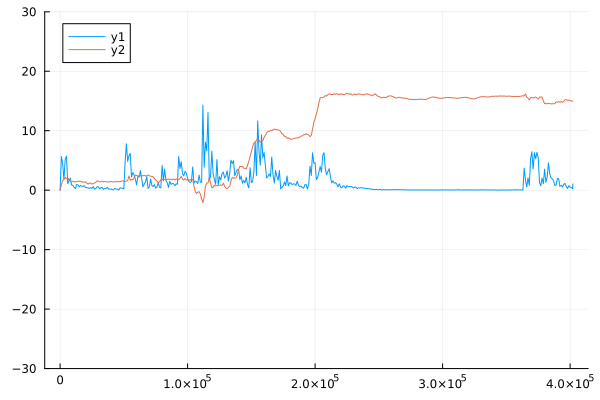

In [2241]:
plot(plot_ts, excited_state_fraction * 1e4)
plot!(plot_ts, z_trajectories, ylim=(-30,30))

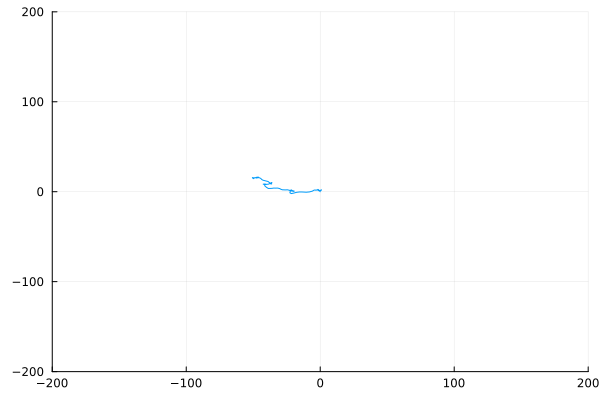

In [2242]:
lim = 200
plot(x_trajectories, z_trajectories, legend=nothing, xlim=(-lim, lim), ylim=(-lim, lim))

In [2243]:
prob.p.n_scatters / t_end

5100.0

In [2244]:
function temperature(v)
    2m * mean(v.^2) / kB
end
;

In [2245]:
1e6 * temperature(x_velocities) |> display
1e6 * temperature(y_velocities) |> display
1e6 * temperature(z_velocities) |> display

7.481196479315739

4.091035043520731

4.586041165200776

In [2246]:
# TODOs
# Try Lambda loading but where the Lambda condition is satisfied at the bottom of the trap

In [2247]:
# 20 W, s = 40, voltage = 40 works pretty well

### Run simulation for multiple particles in parallel

In [2248]:
@everywhere function prob_func(prob, i, repeat)
    
     lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.voltage,
        sim_params.aom_freq
    )
    
    # Define initial conditions for the molecule
    # cloud_size = @with_unit 0.020 "mm"
    cloud_size = @with_unit 0.080 "mm"
    particle = Particle()
    particle.r = (rand(Normal(0, cloud_size)), rand(Normal(0, cloud_size)), rand(Normal(0, cloud_size))) ./ (1/k)
    particle.v = sample_velocity(20e-6) ./ (Γ/k)
    
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    
    p = make_parameters_fast(particle, states, lasers, d, ψ₀, mass, n_excited;
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, H_extra=H_ODT, H_func=H_func)
    
    callback = ContinuousCallback(condition, SE_collapse_pol_always_v2!, nothing, save_positions=(false,false))
    
    prob = ODEProblem(ψ_stochastic_fast!, p.u₀, t_span, p, callback=callback, reltol=5e-4, saveat=1000, maxiters=1000000000)
    
    return prob
end
;

In [2249]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
;

In [2250]:
n_molecules = 20
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
;

176.332899 seconds (1.68 M allocations: 55.028 MiB, 0.02% gc time)


In [2251]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u]./k*1e3 ]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u]./k*1e3 ]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u]./k*1e3 ]
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i],y_trajectories[i],z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

In [2255]:
function survived(times)
    max_idx = maximum(length(time) for time ∈ times)
    _survived = zeros(Bool, length(times))
    for i ∈ eachindex(times)
        _survived[i] = length(times[i]) == max_idx
    end
    return _survived
end
survived_idxs = survived(times)
;

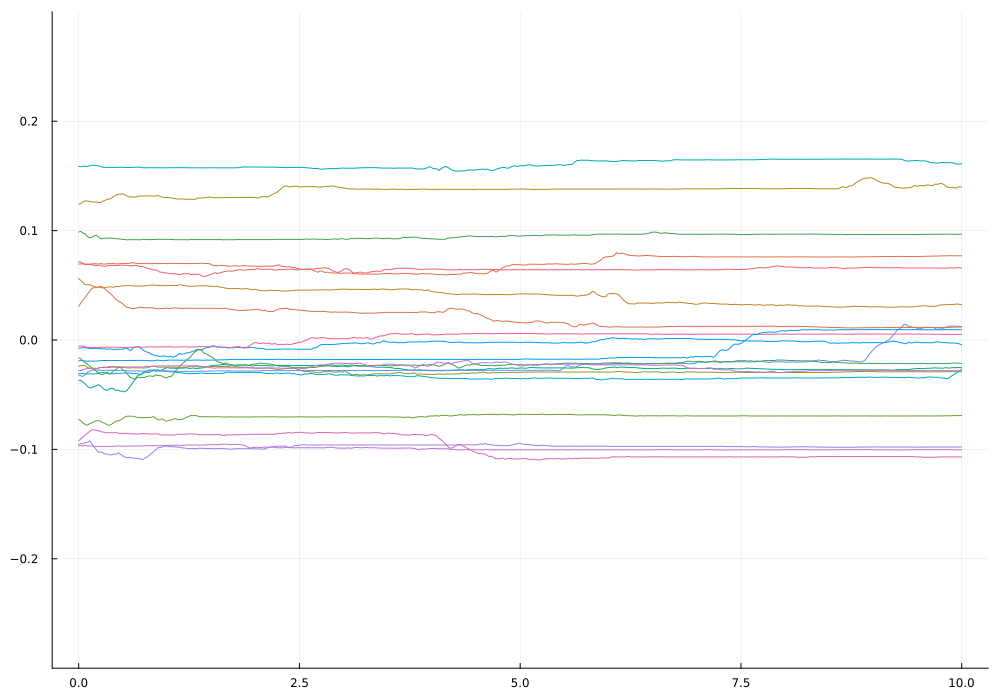

In [2258]:
lim = 0.3
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()
plot!(size=(1000,700))

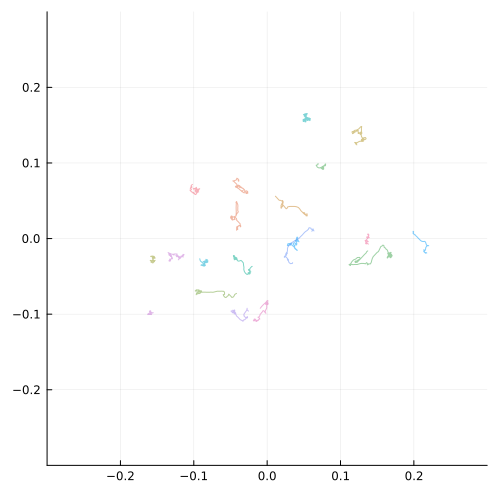

In [2259]:
lim = 0.3
plot(x_trajectories, z_trajectories, legend=nothing, xlim=(-lim, lim), ylim=(-lim, lim), alpha=0.5, size=(500,500))

In [2260]:
using Serialization
# serialize("300e-6 radius spiral.jl", ensemble_sol)

In [2261]:
mean(ensemble_sol[i].prob.p.n_scatters ./ times[i][end] for i ∈ (1:n_molecules)) |> display
mean(ensemble_sol[i].prob.p.n_scatters ./ times[i][end] for i ∈ (1:n_molecules)[_captured]) |> display

7630.0

7500.0

In [2262]:
prob.p.sim_params.ODT_position

2-element Vector{Float64}:
 3.203948315007329e-5
 3.1525207512565956e-5

In [1892]:
_captured = captured_in_ODT(trajectories[survived_idxs], times, 20e-3, prob)
;

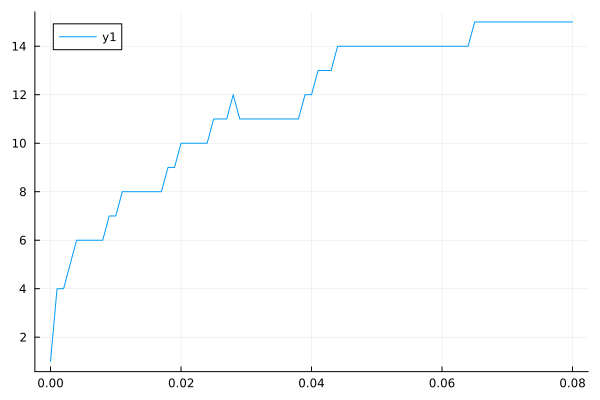

In [1893]:
ts = 0:1e-3:80e-3
captured = []

for t ∈ ts
    _captured = captured_in_ODT(trajectories[survived_idxs], times, t, prob)
    push!(captured, sum(_captured))
end
plot(ts, captured)

In [1877]:
function captured_in_ODT(trajectories, times, t, prob)
    n = 0
    
    update_ODT_center_spiral!(prob.p.sim_params, prob.p.extra_data, t / (1/Γ))
    ODT_position = prob.p.sim_params.ODT_position
    ODT_size = prob.p.sim_params.ODT_size
    
    captured = zeros(Bool, length(trajectories))
    
    for (i,trajectory) ∈ enumerate(trajectories)
        traj_idx = searchsortedfirst(times[i], t)
        if (abs(trajectory[traj_idx][1] - ODT_position[1] * 1e3) <= ODT_size[1] * 1e3) && 
            (abs(trajectory[traj_idx][2]) <= ODT_size[2] * 1e3) &&
            (abs(trajectory[traj_idx][3] - ODT_position[2] * 1e3) <= ODT_size[3] * 1e3)
            captured[i] = true
        end
    end
    return captured
end
;